## Load Conditional WAE model

In [1]:
import os, sys, time, logging, configparser
sys.path.append('/'.join(os.getcwd().split('/')))
import warnings
warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES']='7'
from XAE.dataset import eYaleB, MNIST
from XAE.util import init_params, calculate_sharpness
from XAE.sampler import gaus, multinomial, generate_yale_condition
from XAE.logging_daily import logging_daily
import XAE.fid as fid


import torch
import torch.nn as nn
import torch.optim as optim
from example_mnist.cwae_gan.train import CWAE_GAN_MNIST as current_model

import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

model_home = './example_mnist/cwae_gan'

logger = logging_daily('%s/config/log_info.yaml' % model_home)
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('%s/config/train_config.cfg' % model_home)

test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_data2 = MNIST(cfg['path_info']['data_home'], train = False, label = False, output_channels = 3)

In [3]:
mm = current_model(cfg, log, device = device, verbose = 0)
mm.load('%s/%s' % (model_home, cfg['path_info']['save_path']))

### Reconstruction from test set

In [4]:
test_generator = torch.utils.data.DataLoader(test_data, 16, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
test_sample_image, test_sample_label = next(iter(test_generator))
recon_sample = mm(test_sample_image.to(device), test_sample_label.to(device)).to('cpu').detach().numpy()

In [5]:
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)

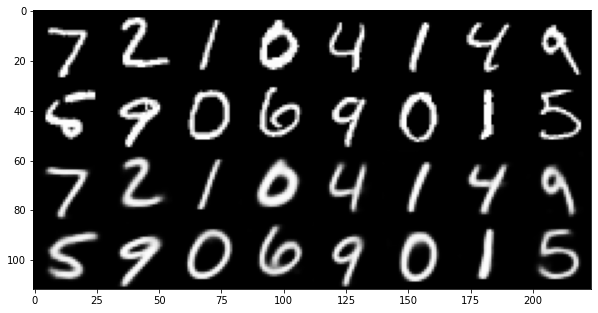

In [6]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show()

### Generation from prior distribution

In [7]:
test_z = []
test_label = []
z = gaus(6, 6)

for i in range(10):
    test_z.append(z)
    test_label.append(test_data.code[i].repeat(6,1))
    
test_z = torch.cat(test_z, dim = 0)
test_label = torch.cat(test_label, dim = 0)

Z = torch.cat([test_z, test_label], dim = 1).to(device)

In [8]:
gen_sample = mm.decode(Z).to('cpu').detach().numpy() # generated samples in numpy

gz = []
for i in range(10):
    gz.append(np.concatenate([gen_sample[6*i + j,0,:,:] for j in range(6)], axis = 1))
generation_result = np.concatenate(gz, axis = 0) # concatenate matrix for plt

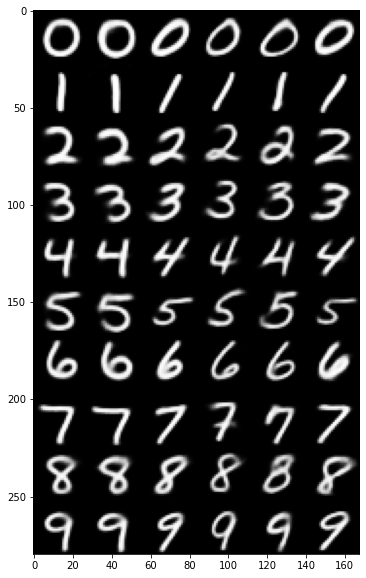

In [9]:
plt.figure(figsize = (6.0, 10.0))
plt.imshow(generation_result, cmap='gray', vmin=-1, vmax=1)
plt.show()

## Sharpness and FID

In [10]:
ss = calculate_sharpness(test_data2, device = device)
ss

array([0.59154326, 0.74747705, 0.38379332, ..., 0.63254058, 0.64670199,
       0.88449651])

In [11]:
ss.mean()

0.730941646450758

In [12]:
fid_model = fid.InceptionV3().to(device)

In [13]:
m1, s1 = fid.calculate_activation_statistics(test_data2, fid_model, batch_size=100, dims=2048, device = device)

100%|██████████| 100/100 [00:29<00:00,  3.40it/s]


In [15]:
z_sampler = lambda x : torch.cat([gaus(x, 6), multinomial(x, 10)], dim = 1).to(device)

In [18]:
act = fid.get_activations_generator(mm.dec, z_sampler, fid_model, batch_size=100, repeat = 10, dims=2048, device=device)
m2 = np.mean(act,axis = 0)
s2 = np.cov(act, rowvar=False)

In [19]:
fid.calculate_frechet_distance(m1, s1, m2, s2)

39.192245177996114

## Interploation between labels

In [14]:
int_label = []
for i in range(9):
    i_to_j = np.zeros((11, 10))
    for j in range(11):
        i_to_j[j, i] = 1 - 0.1*j
        i_to_j[j, i+1] = 0.1*j
    int_label.append(i_to_j)
int_labels = np.concatenate(int_label, axis = 0).astype(np.float32)

In [15]:
z_label = torch.from_numpy(int_labels)
z_latent = torch.zeros((99,6))
Z = torch.cat([z_latent, z_label], dim = 1).to(device)
Z.shape

torch.Size([99, 16])

In [16]:
gen_sample = cwae_MMD.dec(Z).to('cpu').detach().numpy() # generated samples in numpy

gz = []
for i in range(9):
    gz.append(np.concatenate([gen_sample[11*i + j,0,:,:] for j in range(11)], axis = 1))
generation_result = np.concatenate(gz, axis = 0) # concatenate matrix for plt

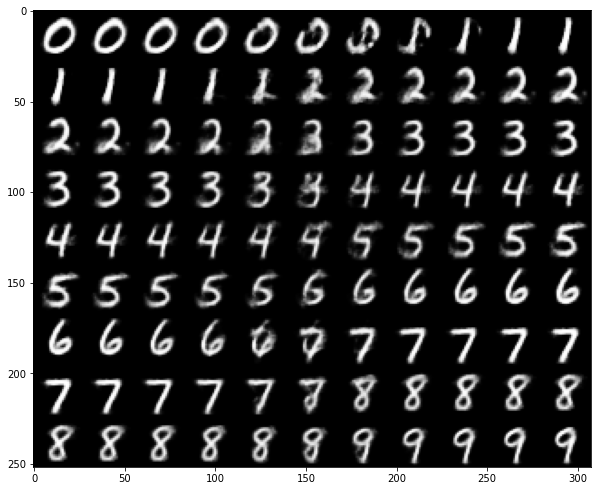

In [17]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(generation_result, cmap='gray', vmin=-1, vmax=1)
plt.show()